# Convergence study

- Experimental setup: 
    - rest length s=1.0
    - we parametrize the force functions such that the relaxation time is 1.0h (If we have time we can study the effect of the force function parameters on the convergence.)
    - repulsion
        - two cells initially placed at a distance of 0.3, ie a overlap of 0.7
        - we simulate until relaxation, ie until t = 1.0h
    - adhesion
        - initial distance of 1.35 (we need to study the influence of the initial distance!)
- Force laws we consider
    - linear (only for repulsion)
    - cubic
    - piecewise quadratic
- solvers
    - RK45 from scipy
    - EF (own implementation)
- Plots
    - l2-norm of the difference of the cell-cell distance between two successive time step values as a function of the number of timesteps.
    - (Alternatively we could plot the error to a reference solution as a function of the number of time steps. Then we would need to make sure that the reference solution is good enough.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import adams_bashforth as ab
import midpoint as md
import heun as he
import cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'font.size': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 1.0  # final time
rA = 1.5   # maximum interaction distance

seed=17

params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': muR*ratio, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls = 1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

In [3]:
solver_names = ['EF', 'AB', 'midpoint']
force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[1], 'GLS': defcolors[3]}

In [4]:
# Solvers
solvers_ef = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, ef.solve_ivp, 1), 
             'cubic': cbmos.CBMSolver(ff.cubic, ef.solve_ivp, 1),
             'GLS': cbmos.CBMSolver(ff.gls, ef.solve_ivp, 1)}
solvers_ab = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, ab.solve_ivp, 1), 
             'cubic': cbmos.CBMSolver(ff.cubic, ab.solve_ivp, 1),
             'GLS': cbmos.CBMSolver(ff.gls, ab.solve_ivp, 1)}
solvers_md = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, md.solve_ivp, 1), 
             'cubic': cbmos.CBMSolver(ff.cubic, md.solve_ivp, 1),
             'GLS': cbmos.CBMSolver(ff.gls, md.solve_ivp, 1)}
solvers_he = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, he.solve_ivp, 1), 
             'cubic': cbmos.CBMSolver(ff.cubic, he.solve_ivp, 1),
             'GLS': cbmos.CBMSolver(ff.gls, he.solve_ivp, 1)}
solver_dicts = {'EF': solvers_ef, 'AB': solvers_ab, 'midpoint': solvers_md}

In [5]:
def asol_hertz(t, mu=1.0):
    c = 2 *np.sqrt(10)/np.sqrt(7)
    return 1.0 - 4/((2*mu*t+c)**2)

In [6]:
mu_hertz = 10 - np.sqrt(10)/np.sqrt(7)

In [7]:
# Initial condition
cell_list = [cl.Cell(0, [0], proliferating=True), cl.Cell(1, [0.3], proliferating=True)]

## Reference solution

In [8]:
t_data_ref = np.linspace(0,1, 100000+1)
ref_sol_dicts = {}
for solver in solver_names:
    solvers = solver_dicts[solver]
    ref_sols = {}
    for force in force_names: 
        history = solvers[force].simulate(cell_list, t_data_ref, params[force], {'dt': 0.00001}, seed=seed)
        ref_sols[force] = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])[:len(t_data_ref)]
    ref_sol_dicts[solver] = ref_sols    

/home/kubuntu1804/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


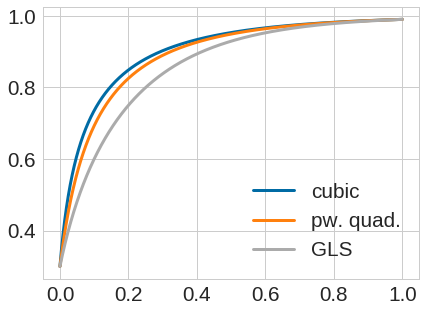

In [9]:
# plot the reference solution
for force in force_names:
    plt.plot(t_data_ref, ref_sol_dicts['midpoint'][force], label=force)
plt.legend()

## Convergence

In [10]:
#dt_values = [0.0001*1.25**n for n in range(0, 32)]
dt_values = [0.001*1.25**n for n in range(0, 22)]


In [11]:
sol_dicts = {}

In [12]:
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,1,dt)
    
    for force in force_names:
        history = solver_dicts['EF'][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        ref = np.squeeze(ref_sol_dicts['EF'][force])
        sol[force].append(np.linalg.norm(inter-ref)/np.linalg.norm(ref))
sol_dicts['EF'] = sol

[1001, 0.001]
[801, 0.00125]
[641, 0.0015625]
[513, 0.001953125]
[410, 0.00244140625]
[328, 0.0030517578125]
[263, 0.003814697265625]
[210, 0.00476837158203125]
[168, 0.0059604644775390625]
[135, 0.007450580596923828]
[108, 0.009313225746154785]
[86, 0.011641532182693481]
[69, 0.014551915228366852]
[55, 0.018189894035458565]
[44, 0.022737367544323206]
[36, 0.028421709430404007]
[29, 0.03552713678800501]
[23, 0.04440892098500626]
[19, 0.05551115123125783]
[15, 0.06938893903907228]
[12, 0.08673617379884035]
[10, 0.10842021724855044]


In [13]:
#for dt, err in zip(dt_values,  sol_dicts['EF']['cubic']):
#    print([dt,err])
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force]) > 0.001)[0][0]]])

['cubic', 0.00125]
['pw. quad.', 0.0015625]
['GLS', 0.001953125]


In [14]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['EF'][force]) > 0.01)[0][0]]])

['cubic', 0.011641532182693481]
['pw. quad.', 0.014551915228366852]
['GLS', 0.018189894035458565]


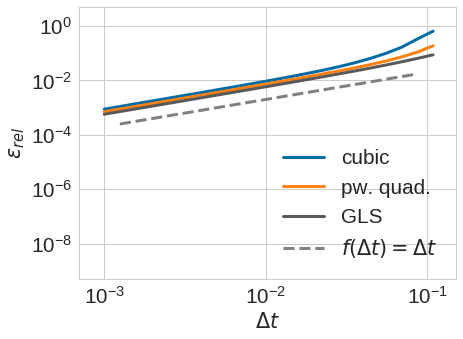

In [15]:
for force in force_names: 
    plt.loglog(dt_values, sol_dicts['EF'][force], label=force, color=colors[force])
plt.loglog(dt_values[1:-1], np.array(dt_values[1:-1])*0.2, '--', label='$f(\Delta t)=\Delta t$', color='grey')
plt.legend(loc='lower right')
#plt.title('Euler forward')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.xlim([7*1e-4, 1.5*1e-1])
plt.ylim([5*1e-10, 5*1e-0])


plt.savefig('relaxation_exp_convergence_ef.pdf', bbox_inches='tight')

In [16]:
solver = 'AB'
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,1,dt)
    
    for force in force_names:
        history = solver_dicts[solver][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        ref = np.squeeze(ref_sol_dicts[solver][force])
        sol[force].append(np.linalg.norm(inter-ref)/np.linalg.norm(ref))
sol_dicts[solver] = sol

[1001, 0.001]
[801, 0.00125]
[641, 0.0015625]
[513, 0.001953125]
[410, 0.00244140625]
[328, 0.0030517578125]
[263, 0.003814697265625]
[210, 0.00476837158203125]
[168, 0.0059604644775390625]
[135, 0.007450580596923828]
[108, 0.009313225746154785]
[86, 0.011641532182693481]
[69, 0.014551915228366852]
[55, 0.018189894035458565]
[44, 0.022737367544323206]
[36, 0.028421709430404007]
[29, 0.03552713678800501]
[23, 0.04440892098500626]
[19, 0.05551115123125783]
[15, 0.06938893903907228]
[12, 0.08673617379884035]
[10, 0.10842021724855044]


In [17]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['AB'][force]) > 0.001)[0][0]]])

['cubic', 0.009313225746154785]
['pw. quad.', 0.011641532182693481]
['GLS', 0.018189894035458565]


In [18]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['AB'][force]) > 0.01)[0][0]]])

['cubic', 0.028421709430404007]
['pw. quad.', 0.03552713678800501]
['GLS', 0.05551115123125783]


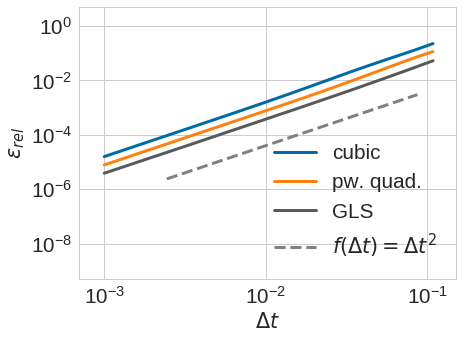

In [19]:
for force in force_names: 
    plt.loglog(dt_values, sol_dicts['AB'][force], label=force, color=colors[force])
plt.loglog(dt_values[4:-1], np.array(dt_values[4:-1])**2*0.4, '--', label='$f(\Delta t)=\Delta t^2$', color='grey')
plt.legend()
#plt.title('Adams-Bashforth')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.xlim([7*1e-4, 1.5*1e-1])
plt.ylim([5*1e-10, 5*1e-0])


plt.savefig('relaxation_exp_convergence_AB.pdf', bbox_inches='tight')

In [20]:
solver = 'midpoint'
sol = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    N = int(1/dt) + 1
    print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,1,dt)
    
    for force in force_names:
        history = solver_dicts[solver][force].simulate(cell_list, t_data, params[force], {'dt': dt}, seed=seed)
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        length = min(len(t_data), len(y))
        inter = np.interp(t_data_ref, t_data[:length], np.squeeze(y[:length]))
        ref = np.squeeze(ref_sol_dicts[solver][force])
        sol[force].append(np.linalg.norm(inter-ref)/np.linalg.norm(ref))
sol_dicts[solver] = sol

[1001, 0.001]
[801, 0.00125]
[641, 0.0015625]
[513, 0.001953125]
[410, 0.00244140625]
[328, 0.0030517578125]
[263, 0.003814697265625]
[210, 0.00476837158203125]
[168, 0.0059604644775390625]
[135, 0.007450580596923828]
[108, 0.009313225746154785]
[86, 0.011641532182693481]
[69, 0.014551915228366852]
[55, 0.018189894035458565]
[44, 0.022737367544323206]
[36, 0.028421709430404007]
[29, 0.03552713678800501]
[23, 0.04440892098500626]
[19, 0.05551115123125783]
[15, 0.06938893903907228]
[12, 0.08673617379884035]
[10, 0.10842021724855044]


In [21]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['midpoint'][force]) > 0.001)[0][0]]])

['cubic', 0.009313225746154785]
['pw. quad.', 0.014551915228366852]
['GLS', 0.022737367544323206]


In [22]:
for force in force_names:
    print([force, dt_values[np.nonzero(np.array(sol_dicts['midpoint'][force]) > 0.01)[0][0]]])

['cubic', 0.028421709430404007]
['pw. quad.', 0.04440892098500626]
['GLS', 0.06938893903907228]


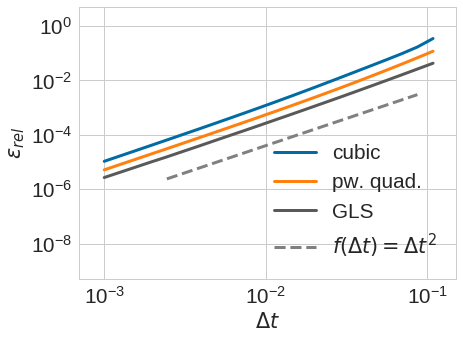

In [23]:
for force in force_names: 
    plt.loglog(dt_values, sol_dicts['midpoint'][force], label=force, color=colors[force])
plt.loglog(dt_values[4:-1], np.array(dt_values[4:-1])**2*0.4, '--', label='$f(\Delta t)=\Delta t^2$', color='grey')
plt.legend()
#plt.title('Midpoint')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.xlim([7*1e-4, 1.5*1e-1])
plt.ylim([5*1e-10, 5*1e-0])


plt.savefig('relaxation_exp_convergence_midpoint.pdf', bbox_inches='tight')

$\epsilon_{rel} = ||y_{dt} -y_{ref}||_2/ ||y_{ref}||_2$


## Plot different solvers in single figure for each force law

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[1], 'GLS': defcolors[2]}
linestyles = {'EF': '-', 'AB': '-.', 'midpoint': '--', 'Heun': ':'}

for solver in solver_names: 
    #for force in force_names: 
    plt.loglog(dt_values, sol_dicts[solver]['cubic'], label=solver, color=colors['cubic'], linestyle=linestyles[solver])
plt.loglog(dt_values[2:-4], np.array(dt_values[2:-4])*4, '--', label='f(x)=x', color='grey')
plt.loglog(dt_values[4:-4], np.array(dt_values[4:-4])**2*0.8, '-.', label='$f(x)=x^2$', color='grey')
#plt.legend()
plt.title('Cubic')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.savefig('convergence_cubic.pdf', bbox_inches='tight')

for solver in solver_names: 
    #for force in force_names: 
    plt.loglog(dt_values, sol_dicts[solver]['pw. quad.'], label=solver, color=colors['pw. quad.'], linestyle=linestyles[solver])
plt.loglog(dt_values[2:-4], np.array(dt_values[2:-4])*4, '--', label='f(x)=x', color='grey')
plt.loglog(dt_values[4:-4], np.array(dt_values[4:-4])**2*0.8, '-.', label='$f(x)=x^2$', color='grey')
#plt.legend()
plt.title('Piecewise quadratic')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.savefig('convergence_pwq.pdf', bbox_inches='tight')

plt.loglog(0.005*np.ones((10,1)), np.linspace(10^-5, 2*10^0, 10),':', color='grey', alpha=0.5)
plt.loglog(0.075*np.ones((10,1)), np.linspace(10^-5, 10^0, 10), ':', color='grey', alpha=0.5)
#plt.loglog(np.linspace(0.0001, 0.1, 10),0.01*np.ones((10,1)), ':', color='grey', alpha=0.5)

for solver in ['EF', 'midpoint']: 
    for force in force_names: 
        plt.loglog(dt_values, sol_dicts[solver][force], color=colors[force], linestyle=linestyles[solver])
plt.loglog(dt_values[2:-4], np.array(dt_values[2:-4])*4, '-', label='$f(\Delta t)= \Delta t$', color='grey')
plt.loglog(dt_values[4:-4], np.array(dt_values[4:-4])**2*0.8, '--', label='$f(\Delta t)= \Delta t^2$', color='grey')


#plt.loglog(0.1*np.ones((10,1)), np.linspace(10^-6, 1, 10), color='grey')
plt.ylim([0.00000001, 10])
plt.legend()

#plt.title('Piecewise quadratic')
plt.xlabel('$\Delta t$')
plt.ylabel('$\epsilon_{rel}$')
plt.savefig('convergence_pwq_cubic_gls_ef_md.pdf', bbox_inches='tight')
plt.savefig('convergence_pwq_cubic_gls_ef_md.png', bbox_inches='tight')

Colors: blue - cubic, green - pw. quad, red - GLS. Linestyles: full - EF, dashed - Midpoint's 